In [398]:
using Optim
using Plots
using Statistics
using NLsolve

In [399]:
###
### Alternative method for iterating over the value function
###

function fun_max(mX)
   
    # Find maximum of a matrix along the columns
    # Input: mX of dimension m x n
    # Output vMax of dimension n
    iCols = size(mX, 2);
    vMax = zeros(iCols,1);
    for i = 1:iCols
            temp_max = findmax( mX[:,i] );
            vMax[i] = temp_max[1];
    end
    
    return vMax;
    
end

function fun_max_index(mX)
   
    # Find maximum of a matrix along the columns
    # and give the index
    # Input: mX of dimension m x n
    # Output vMax of dimension n
    iCols = size(mX, 2);
    vMax_index = zeros(iCols,1);
    for i = 1:iCols
            temp_max = findmax( mX[:,i] );
            vMax_index[i] = temp_max[2];
    end
    
    return vMax_index;
    
end


# Structural parameters
pAlpha = 0.36;
pBeta = 0.99;
pDelta = 0.022;
pTheta = 1;
pEta = 1;
pMu_m = 1;
pGamma = 0.05;
pGamma_n = -1/1.25;
pAlpha_m = 0.40;
pRho_x = 0.07;
pMu = 0.004;
pA = 0.05;
pC0 = 0.005;
pRho = 0.95;
pSigmaeps = 0.007;
pMuz = 1;


# Computing the steady state values
PARAMS = [ pAlpha, pAlpha_m, pTheta, pGamma_n, pC0, pEta, pDelta, pRho_x, pMu_m, pGamma, pBeta ];
function f!(F,x,PARAMS)
    
    # 1  2  3  4  5    6     7
    # c, v, s, k, n, lambda, mu
    
    pAlpha = PARAMS[1];
    pAlpha_m = PARAMS[2];
    pTheta = PARAMS[3];
    pGamma_n = PARAMS[4];
    pC0 = PARAMS[5];
    pEta = PARAMS[6];
    pDelta = PARAMS[7];
    pRho_x = PARAMS[8];
    pMu_m = PARAMS[9];
    pGamma = PARAMS[10];
    pBeta = PARAMS[11];    
    
    F[1] = x[4]^pAlpha*x[5]^(1-pAlpha) -pDelta*x[4] -pC0*x[3]^pEta*(1-x[5])-pGamma*x[2]-x[1]
    F[2] = (1-pRho_x)*x[5] + pMu_m*x[2]^(1-pAlpha_m)*( x[3]*(1-x[5]) )^pAlpha_m - x[5]
    F[3] = pBeta*( pAlpha*x[4]^(pAlpha-1)*x[5]^(1-pAlpha) + (1-pDelta) ) - 1
    F[4] = pBeta*( -pTheta*x[5]^(-pGamma_n) + x[6]*( (1-pAlpha)*x[4]^pAlpha*x[5]^(-pAlpha)+pC0*x[3]^pEta ) + x[7]*( (1-pRho_x)-pMu_m*pAlpha_m*x[2]^(1-pAlpha_m)*x[3]^pAlpha_m*(1-x[5])^(pAlpha_m-1) ) ) - x[7]
    F[5] = 1/x[1] - x[6]
    F[6] = x[7]*( pMu_m*(1-pAlpha_m)*x[2]^(-pAlpha_m)*( x[3]*(1-x[5]) )^(pAlpha_m) )-pGamma*x[6]
    F[7] = x[7]*pMu_m*x[2]^(1-pAlpha_m)*pAlpha_m*x[3]^(pAlpha_m-1)*(1-x[5])^pAlpha_m-x[6]*pC0*pEta*x[3]^(pEta-1)*(1-x[5]) 
    
end 


SteadyState = nlsolve((F,x) ->f!(F,x,PARAMS), [ 2.67, 0.02, 2.3, 39, 0.92, 0.37, 0.01 ], iterations = 1000 , method = :newton)

# Defining the steady state
dSss = SteadyState.zero[3];
dKss = SteadyState.zero[4];
dNss = SteadyState.zero[5];




In [400]:
# Algorithm related parameters
iIter = 15000; 
iGridPointsK = 3;
iGridPointsN = 2;
iToler = 10e-6;  

# Constructing the grid
dKmin = dKss * 0.999;
dKmax = dKss * 1.001;
dNmin = dNss * 0.999;
dNmax = dNss * 1.001;


iStepK = (dKmax-dKmin) / (iGridPointsK-1);
vK = collect(dKmin:iStepK:dKmax);
iGridPointsK = size(vK,1);

iStepN = (dNmax-dNmin) / (iGridPointsN-1);
vN = collect(dNmin:iStepN:dNmax);
iGridPointsN = size(vN,1);


# Illustration of the state space with three grid-points in K
# and two grid-points in N
#
#             -----------------     -----------------
#       K1'   | o     o     o |     | o     o     o |
#  N1'  K2'   | o     o     o |     | o     o     o |
#       K3'   | o     o     o |     | o     o     o |
#            -----------------     -----------------
#
#             -----------------     -----------------
#       K1'   | o     o     o |     | o     o     o |
#  N2'  K2'   | o     o     o |     | o     o     o |
#       K3'   | o     o     o |     | o     o     o |
#             -----------------     -----------------
#               K1    K2    K3        K1    K2    K3
#                     N1                    N2

#print( vN );
#print("\n");
#print( vK );

#mC = zeros(iGridPointsK*iGridPointsN, iGridPointsK*iGridPointsN);
mV1 = zeros(iGridPointsN,iGridPointsN);
mV2 = zeros(iGridPointsN,iGridPointsN);

A = zeros(iGridPointsN,iGridPointsN);
B = zeros(iGridPointsN,iGridPointsN);
mV = zeros(iGridPointsN,iGridPointsN);

TEMP1 = zeros(iGridPointsK*iGridPointsN, iGridPointsK*iGridPointsN);
TEMP2 = zeros(iGridPointsK*iGridPointsN, iGridPointsK*iGridPointsN);
TEMP3 = zeros(iGridPointsK*iGridPointsN, iGridPointsK*iGridPointsN);
TEMP4 = zeros(iGridPointsK*iGridPointsN, iGridPointsK*iGridPointsN);



for idxN = 1:iGridPointsN
    for idxNp = 1:iGridPointsN
        for idxK = 1:iGridPointsK
            for idxKp = 1:iGridPointsK
                # columns are indexed by "idxK" and represent current capital
                # rows are indexed by "idxKp" and represent next period capital
                # columns are indexed by "idxN" and represent current employment
                # rows are indexed by "idxNp" and represent next period employment  
                
                A[idxNp,idxN] = vN[idxNp] - ( 1-pRho_x )*vN[idxN];
                B[idxNp,idxN] = pMu_m*dSss*(1-vN[idxN])*pAlpha_m;
                mV[idxNp,idxN] = ( A[idxNp,idxN]/B[idxNp,idxN] )^( 1/(1-pAlpha_m) ) ;
                
                TEMP1[idxKp+iGridPointsK*(idxNp-1),idxK+iGridPointsK*(idxN-1)] =
                        vK[idxK]^(pAlpha)*vN[idxN]^(1-pAlpha);
                TEMP2[idxKp+iGridPointsK*(idxNp-1),idxK+iGridPointsK*(idxN-1)] =
                        -vK[idxKp] + (1-pDelta)*vK[idxK];
                TEMP3[idxKp+iGridPointsK*(idxNp-1),idxK+iGridPointsK*(idxN-1)] =
                        - pC0*dSss^pEta*( 1-vN[idxN] );
                TEMP4[idxKp+iGridPointsK*(idxNp-1),idxK+iGridPointsK*(idxN-1)] =
                        - pGamma*mV[idxNp,idxN];
                
            end
        end
    end
end 

mC = TEMP1+TEMP2+TEMP3+TEMP4;

#print( mC );
#print("\n");


In [401]:

# Eliminate negative consumption
mCP = mC .> 0;
mPC = ones(iGridPointsK*iGridPointsN, iGridPointsK*iGridPointsN) - mCP;
z = 10e-5;
mC = mC.*mCP + z*mPC;

# Compute utility function
mU = log.(mC)

# Initialize value function

mCF = mC;
for idxN = 1:iGridPointsN
    for idxNp = 1:iGridPointsN
        for idxK = 1:iGridPointsK
            for idxKp = 1:iGridPointsK

                mCF[idxKp+iGridPointsK*(idxNp-1),idxK+iGridPointsK*(idxN-1)] =
                    log(mC[idxKp+iGridPointsK*(idxNp-1),idxK+iGridPointsK*(idxN-1)])
                    - pTheta*( vN[idxN]^(1-pGamma_n) / (1-pGamma_n) )
                
            end
        end
    end
end 

#print( mCF ) 

mVNew = log.(mCF);

vVOld = fun_max( mU+pBeta*mVNew ); # ( [iGridPointsK*iGridPointsN] x 1 )

counter = 0;
### Main Iteration - BEGIN ###
for idxIter=1:iIter

 vVNew = fun_max(mU+pBeta*(ones(iGridPointsN*iGridPointsK,1)*vVOld')');

 iDiff = ( abs.(vVOld-vVNew) ) ./ vVOld; 
    
 if sum(sqrt.((iDiff).^2)) <= iToler
  vVOld = vVNew;
  break
 else
  vVOld = vVNew;
 end
 
 counter = counter + 1;  
    
end
### Main Iteration - END ###

print("\n");
print("\n");
print("Iterations needed to reach convergence : ")
print(counter);
print("\n");





Iterations needed to reach convergence : 865


In [402]:
# Preparing maximum values and indices for policy function
maxR = fun_max(mU+pBeta*(ones(iGridPointsK*iGridPointsN,1)*vVOld')');
idxR = fun_max_index(mU+pBeta*(ones(iGridPointsK*iGridPointsN,1)*vVOld')');

#print(maxR);
#print("\n");
#print(idxR);
#print("\n");
#print(vK);

In [403]:
# Extending the grid where we evaluate variables
vK_L = kron( ones(iGridPointsN,1), vK );
vN_L = kron(vN, ones(iGridPointsK));

# Constructing policy functions
vKP = zeros(iGridPointsN*iGridPointsK,1);
vC_L = zeros(iGridPointsN*iGridPointsK,1);
vNP = zeros(iGridPointsN*iGridPointsK,1);

VA = zeros(iGridPointsN*iGridPointsK,1);
VB = zeros(iGridPointsN*iGridPointsK,1);
vV = zeros(iGridPointsN*iGridPointsK,1);

for i = 1:(iGridPointsN*iGridPointsK)
        # Next period capital and employment
        vKP[i] = vK_L[ floor(Int, idxR[i]) ];
        vNP[i]= vN_L[ floor(Int, idxR[1]) ];
        # Vacancy
        VA[i] = vNP[i] - ( 1-pRho_x )*vN_L[ floor(Int, idxR[i]) ];
        VB[i] = pMu_m*dSss*(1-vN_L[ floor(Int, idxR[i]) ])*pAlpha_m;
        vV[i] = ( VA[i]/VB[i] )^( 1/(1-pAlpha_m) ) ;
        # Consumption
        vC_L[i] = vK_L[ floor(Int, idxR[i]) ].^pAlpha*vN_L[ floor(Int, idxR[i]) ].^(1-pAlpha) 
                    - vKP[i] + (1-pDelta)*vK_L[ floor(Int, idxR[i]) ]
                    - pC0*( 1-vN_L[ floor(Int, idxR[i]) ] )
                    - pGamma*vV[i]
                    ;
end

#plot(vK_L,vC_L, legend = false)
#colN = 5;
#plot(vK_L[colN*iGridPointsK+1:colN*iGridPointsK+iGridPointsK],vC_L[colN*iGridPointsK+1:colN*iGridPointsK+iGridPointsK], legend = false)
#xlabel!("K")
#ylabel!("C")
#print(vC_L)
#print("\n")
#print(vK_L)


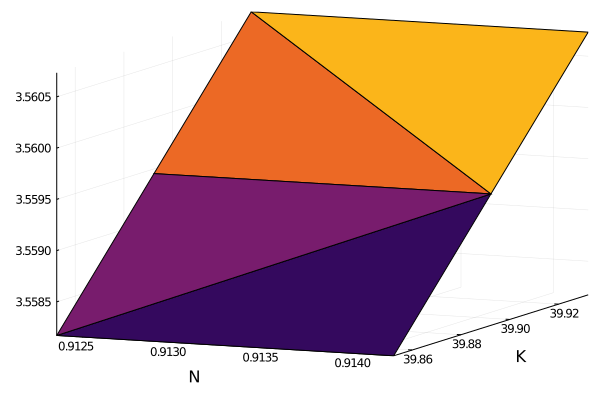

Arrays have incorrect length or dimension.


In [404]:
import PyPlot
vN_Ln = reshape(vN_L,iGridPointsK*iGridPointsN,1);
vK_Ln = reshape(vK_L,iGridPointsK*iGridPointsN,1);
vC_Ln = reshape(vC_L,iGridPointsK*iGridPointsN,1);
#plot(vN_Ln,vK_Ln,vC_Ln,seriestype=:scatter,legend=false)
plot(vN_Ln,vK_Ln,vC_Ln, st = [:surface, :contourf],legend=false)


xlabel!("N")
ylabel!("K")


In [405]:
using NLsolve

function f!(F, v)
           x = v[1]
           y = v[2]
           F[1] = x + 2 - y
           F[2] = x + y -4
       end

res = nlsolve(f!, [0.0; 0.0])

res.zero


2-element Array{Float64,1}:
 1.0000000000043172
 2.999999999991715

In [406]:
function f!(F,x,a,b)
   F[1] = a * sin(x[1]) + b
 end 
a = 1.0
b = 0.5 
nlsolve((F,x) ->f!(F,x,a,b), [ 0.])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0]
 * Zero: [-0.5235987687270582]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4